# **Mall Customer Segmentation & Analysis**

## Data Exploration

In this project I will be using a dataset of customer data in order to segment the customers in a way that can help the marketing department can better plan and strategize. First I will import a few necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
import kagglehub

And also download the dataset:

In [2]:
path = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")

In [3]:
df = pd.read_csv(path + "/Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.shape

(200, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


So the dataset consists of 5 columns, designating a customer's ID, gender, Age, Annual Income, and Spending Score. Spending Score is an attribute assigned to the customer's by the mall based off of their average activity and spending nature.

In [6]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [7]:
df.dtypes

,0
CustomerID,int64
Gender,object
Age,int64
Annual Income (k$),int64
Spending Score (1-100),int64


In [8]:
df.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


Now that we have a decent idea of what the dataset contains, and are aware that there aren't any null values to take care of, we can begin to visualize the data to find out some insights.

## Data Visualization

In [9]:
plt.style.use('ggplot')

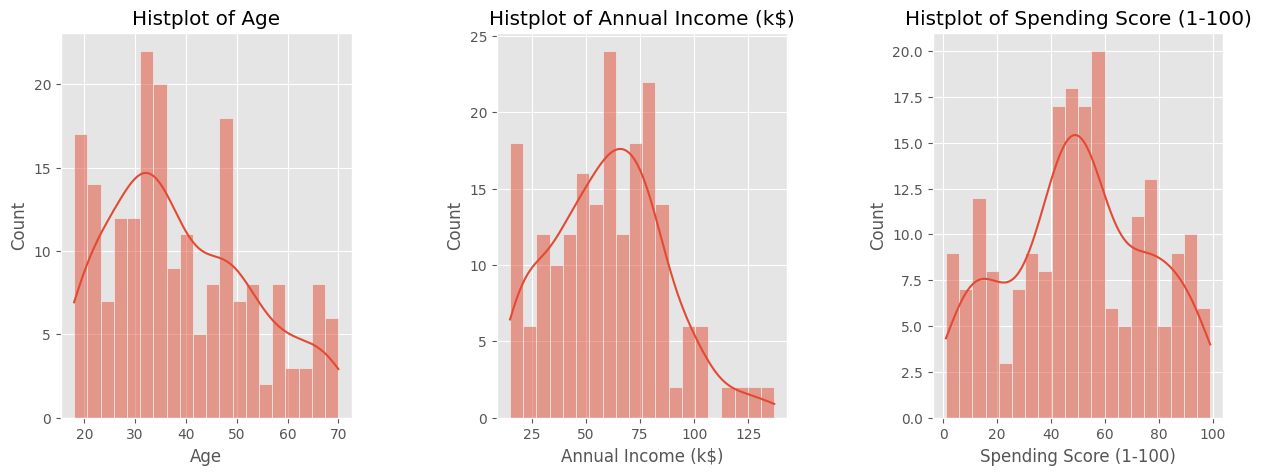

In [10]:
plt.figure(1, figsize=(15, 5))
n = 0
for x in ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1, 3, n)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    sns.histplot(df[x], bins=20, kde=True)
    plt.title(f'Histplot of {x}')
plt.show()

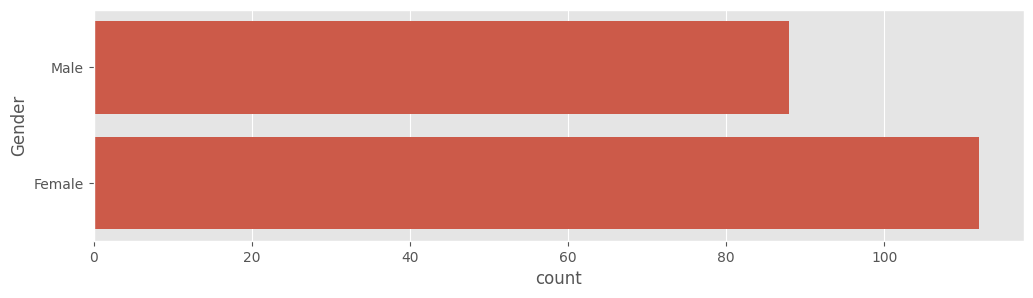

In [11]:
plt.figure(1, figsize=(12, 3))
sns.countplot(y='Gender', data=df)
plt.show()

Relationship Between Age, Annual Income, and Spending Score of customers

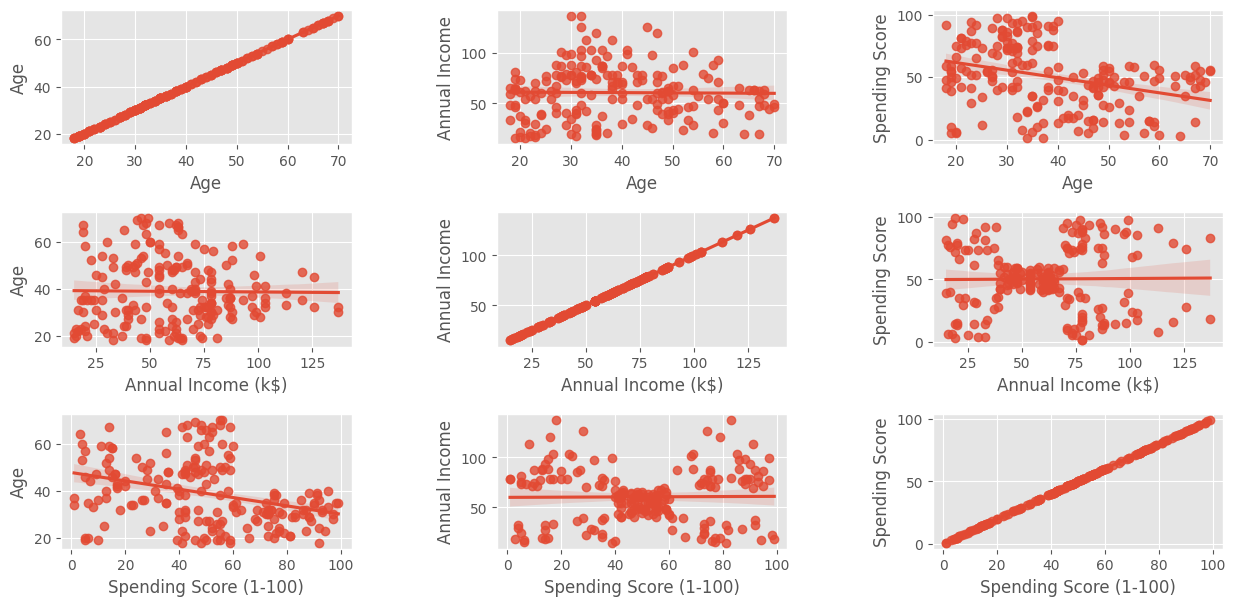

In [12]:
plt.figure(1 , figsize = (15 , 7))
n = 0
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    for y in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
        n += 1
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
plt.show()

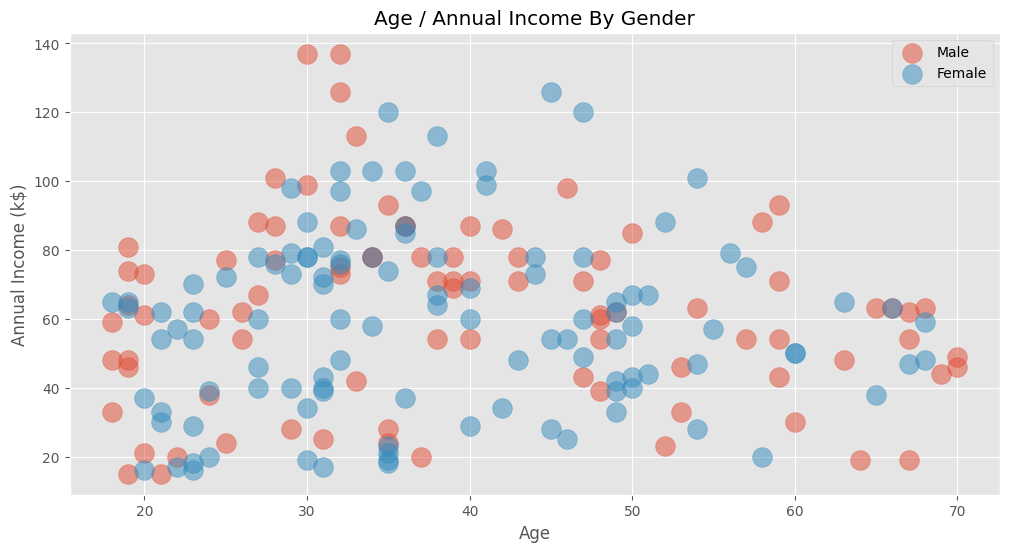

In [13]:
plt.figure(1 , figsize = (12 , 6))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Age' , y = 'Annual Income (k$)' , data = df[df['Gender'] == gender] ,
                s = 200 , alpha = 0.5 , label = gender)
plt.xlabel('Age'), plt.ylabel('Annual Income (k$)')
plt.title('Age / Annual Income By Gender')
plt.legend()
plt.show()

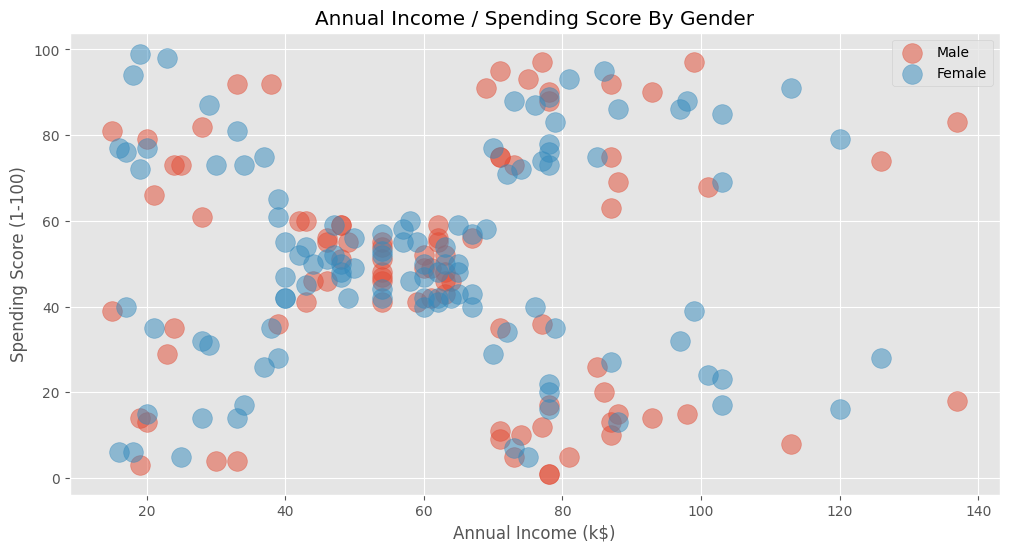

In [14]:
plt.figure(1 , figsize = (12 , 6))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Annual Income (k$)',y = 'Spending Score (1-100)' ,
                data = df[df['Gender'] == gender] ,s = 200 , alpha = 0.5 , label = gender)
plt.xlabel('Annual Income (k$)'), plt.ylabel('Spending Score (1-100)')
plt.title('Annual Income / Spending Score By Gender')
plt.legend()
plt.show()

Box & Swarmplots of value distribution for Age, Annual Income, and Spending Score By Gender

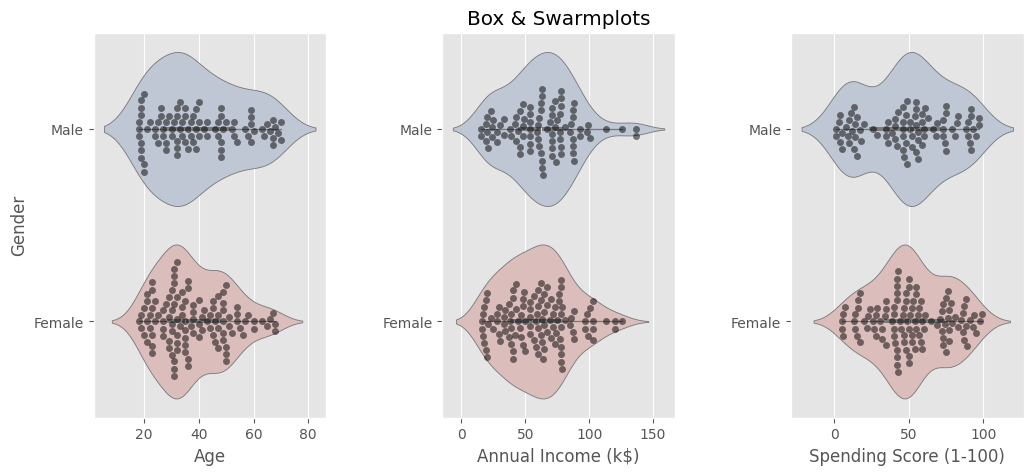

In [15]:
plt.figure(1, figsize=(12, 5))
n = 0
for cols in ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1, 3, n)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    # Updated to use hue='Gender' and legend=False
    sns.violinplot(x=cols, y='Gender', data=df, hue='Gender', palette='vlag', legend=False)
    sns.swarmplot(x=cols, y='Gender', data=df, color='k', alpha=0.5, dodge=True)

    plt.ylabel('Gender' if n == 1 else '')
    plt.title('Box & Swarmplots' if n == 2 else '')
plt.show()

Now that we've effectively visualized the data and seen the correlations between certian values, it's time to begin the actual process of segmenting the customers.

## Clustering & Segmentation

In order to decide which values perform the best for clustering, I will try multiple different combinations of values.

In [16]:
# Segmenting Using Annual Income & Spending Score

# Extracts 2 columns from dataframe: Annual Income and Spending Score
X1 = df[['Annual Income (k$)' , 'Spending Score (1-100)']].iloc[: , :].values

# intializes empty list to store inertia values
inertia = []

# tests range of 1 to 10 clusters for K Means and stores inertia values
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300,
                        tol=0.0001, random_state=110, algorithm='elkan') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

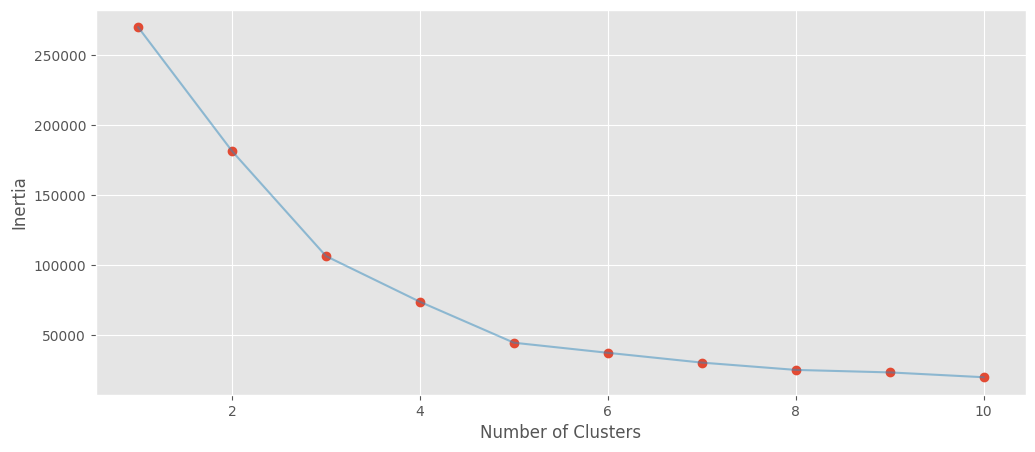

In [17]:
plt.figure(1 , figsize = (12 ,5))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [18]:
algorithm = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=300,
                        tol=0.0001,  random_state= 110  , algorithm='elkan') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

df['label1'] =  labels1

In [19]:
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z1 = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

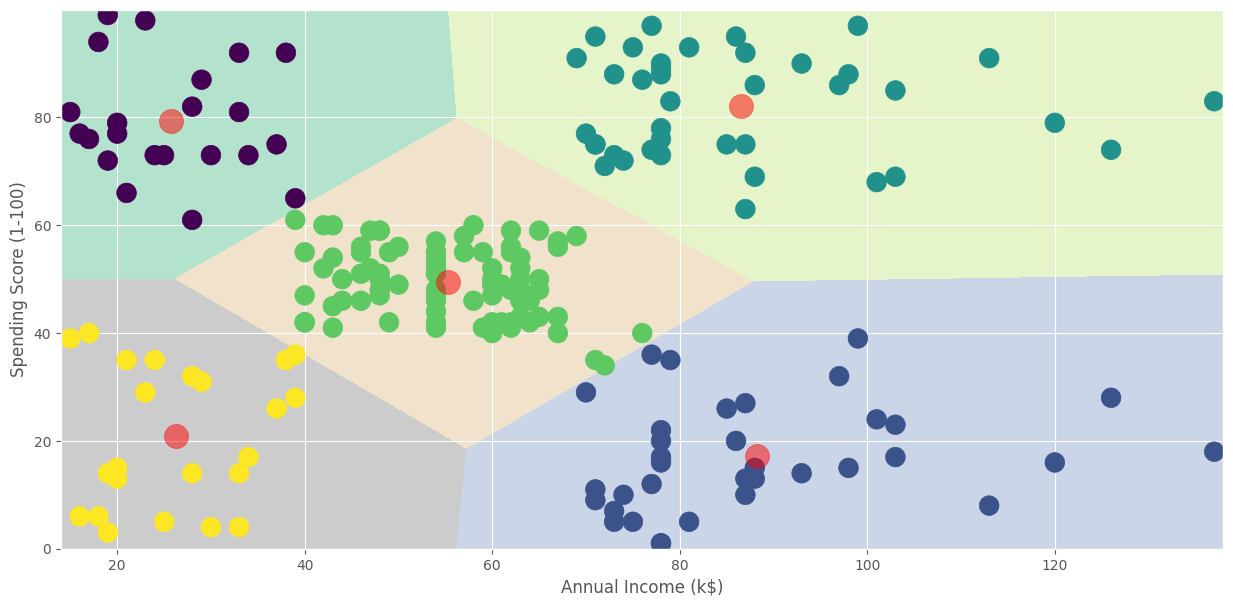

In [20]:
plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z1 = Z1.reshape(xx.shape)
plt.imshow(Z1 , interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Annual Income (k$)' ,y = 'Spending Score (1-100)' , data = df , c = labels1 ,
            s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Annual Income (k$)')
plt.show()

In [21]:
silhouette_score(X1, labels1)

0.553931997444648

In [22]:
# Segmenting Using Age & Spending Score

X2 = df[['Age' , 'Spending Score (1-100)']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300,
                        tol=0.0001,  random_state= 110  , algorithm='elkan') )
    algorithm.fit(X2)
    inertia.append(algorithm.inertia_)

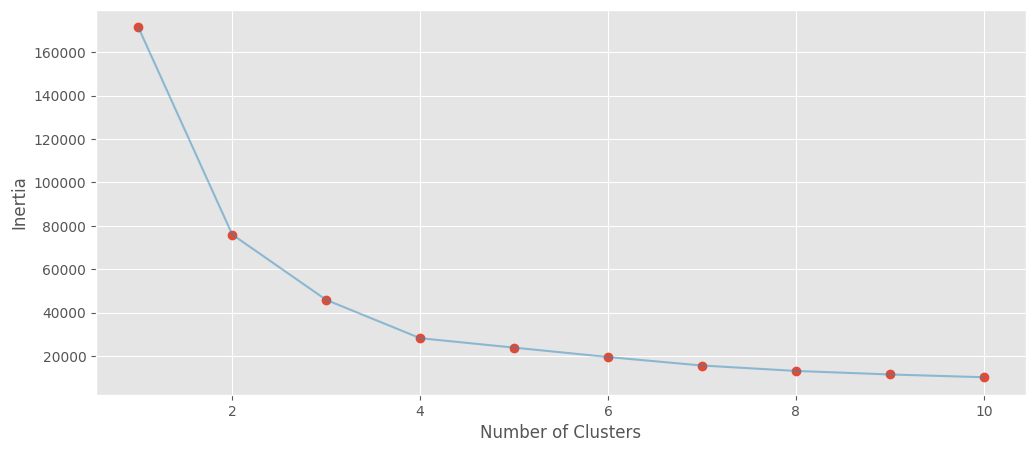

In [23]:
plt.figure(1 , figsize = (12 ,5))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [24]:
algorithm = (KMeans(n_clusters = 4,init='k-means++', n_init = 10 ,max_iter=300,
                        tol=0.0001,  random_state= 110  , algorithm='elkan') )
algorithm.fit(X2)
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

df['label2'] =  labels2

In [25]:
h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z2 = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

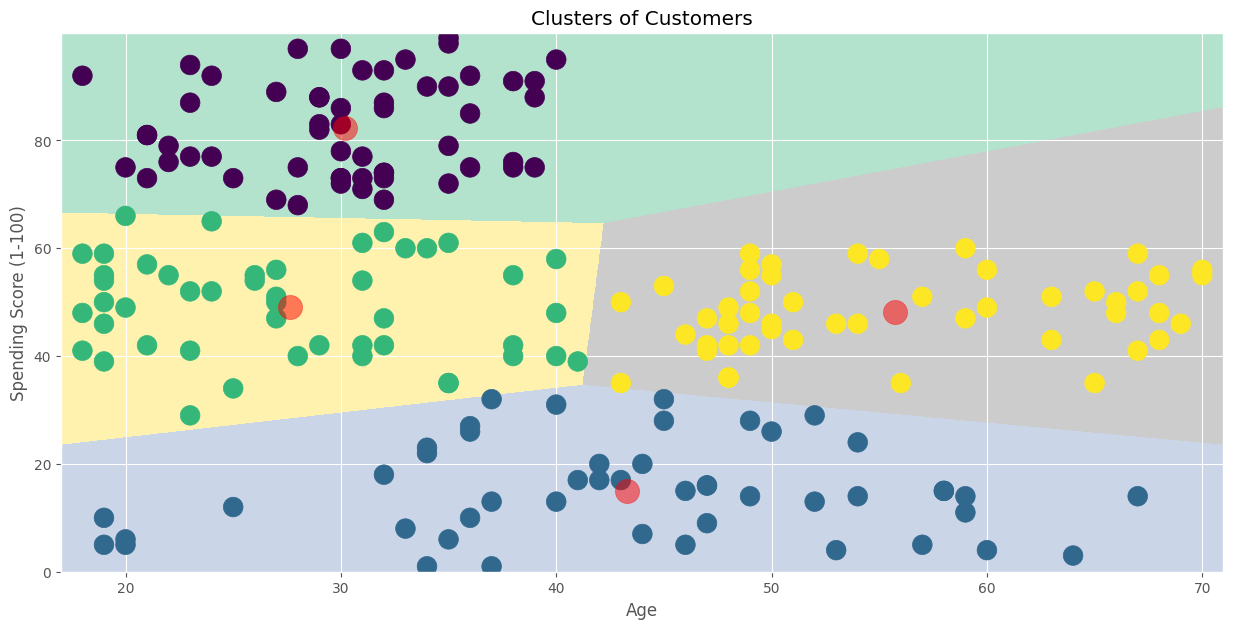

In [26]:
plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z2.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Age' ,y = 'Spending Score (1-100)' , data = df , c = labels2 ,
            s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Age')
plt.title('Clusters of Customers')
plt.show()

In [27]:
silhouette_score(X2, labels2)

0.49973941540141753

In [28]:
# Segmentation Using Age, Annual Income, & Spending Score

X3 = df[['Age' , 'Annual Income (k$)' ,'Spending Score (1-100)']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300,
                        tol=0.0001,  random_state= 110  , algorithm='elkan') )
    algorithm.fit(X3)
    inertia.append(algorithm.inertia_)

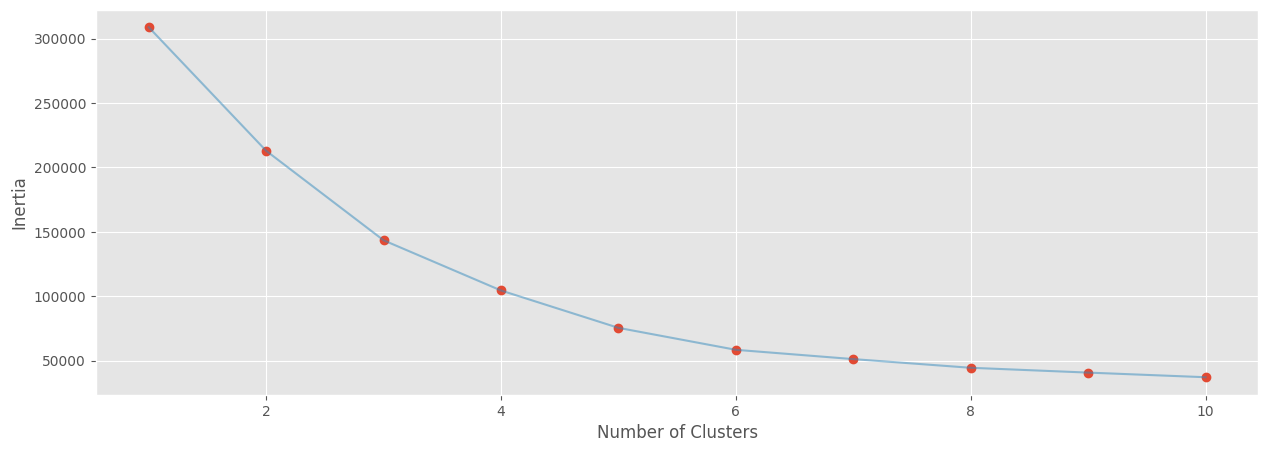

In [29]:
plt.figure(1 , figsize = (15 ,5))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [30]:
algorithm = (KMeans(n_clusters =  5,init='k-means++', n_init = 10 ,max_iter=300,
                        tol=0.0001,  random_state= 110  , algorithm='elkan') )
algorithm.fit(X3)
labels3 = algorithm.labels_
centroids3 = algorithm.cluster_centers_

In [31]:
df['label3'] =  labels3
trace1 = go.Scatter3d(
    x= df['Age'],
    y= df['Spending Score (1-100)'],
    z= df['Annual Income (k$)'],
    mode='markers',
     marker=dict(
        color = df['label3'],
        size= 15,
        line=dict(
            color= df['label3'],
            width= 10
        ),
        opacity=1
     )
)
data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
    title= 'Clusters of Customers',
    scene = dict(
            xaxis = dict(title  = 'Age'),
            yaxis = dict(title  = 'Spending Score'),
            zaxis = dict(title  = 'Annual Income')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [32]:
silhouette_score(X3, labels3)

0.44428597560893024

Exporting Data for creation of Tableau Dashboard

In [33]:
#df.to_csv('Mall_Customers_Segmented.csv', index=False)

In [34]:
#from google.colab import files
#files.download('Mall_Customers_Segmented.csv')

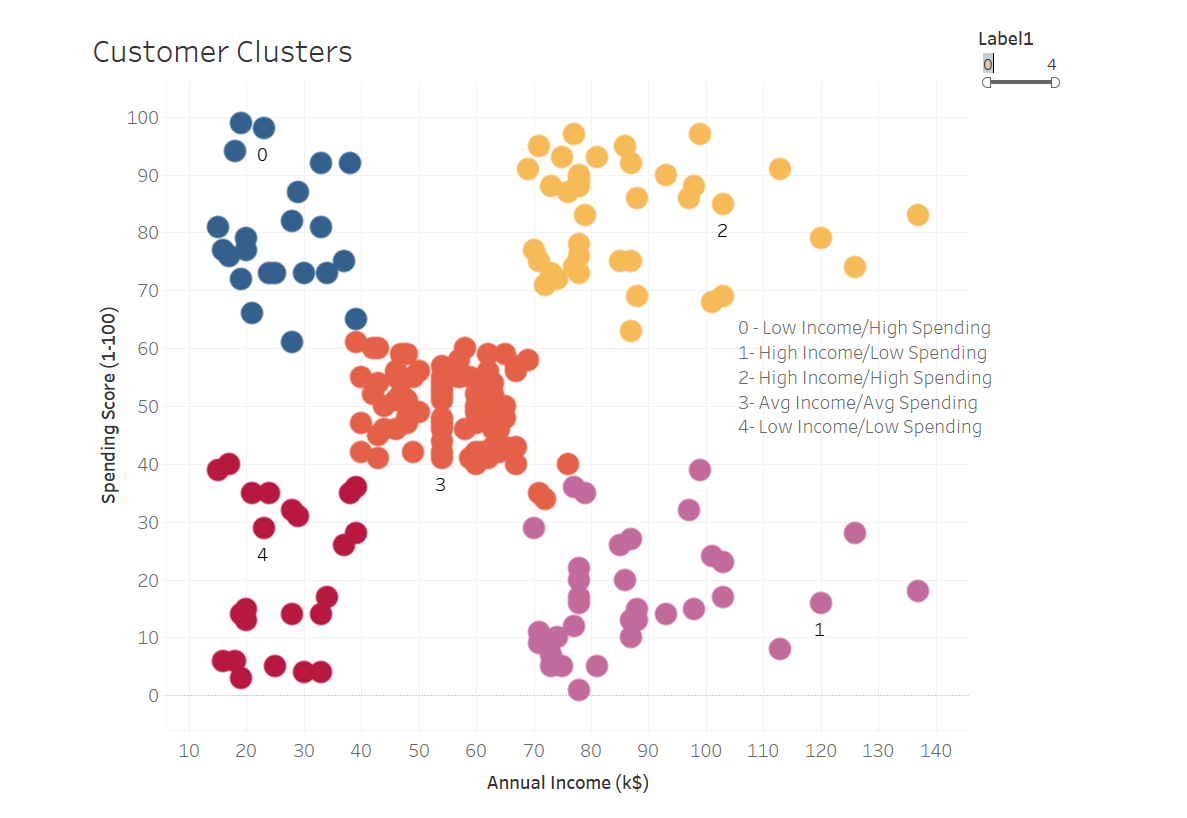

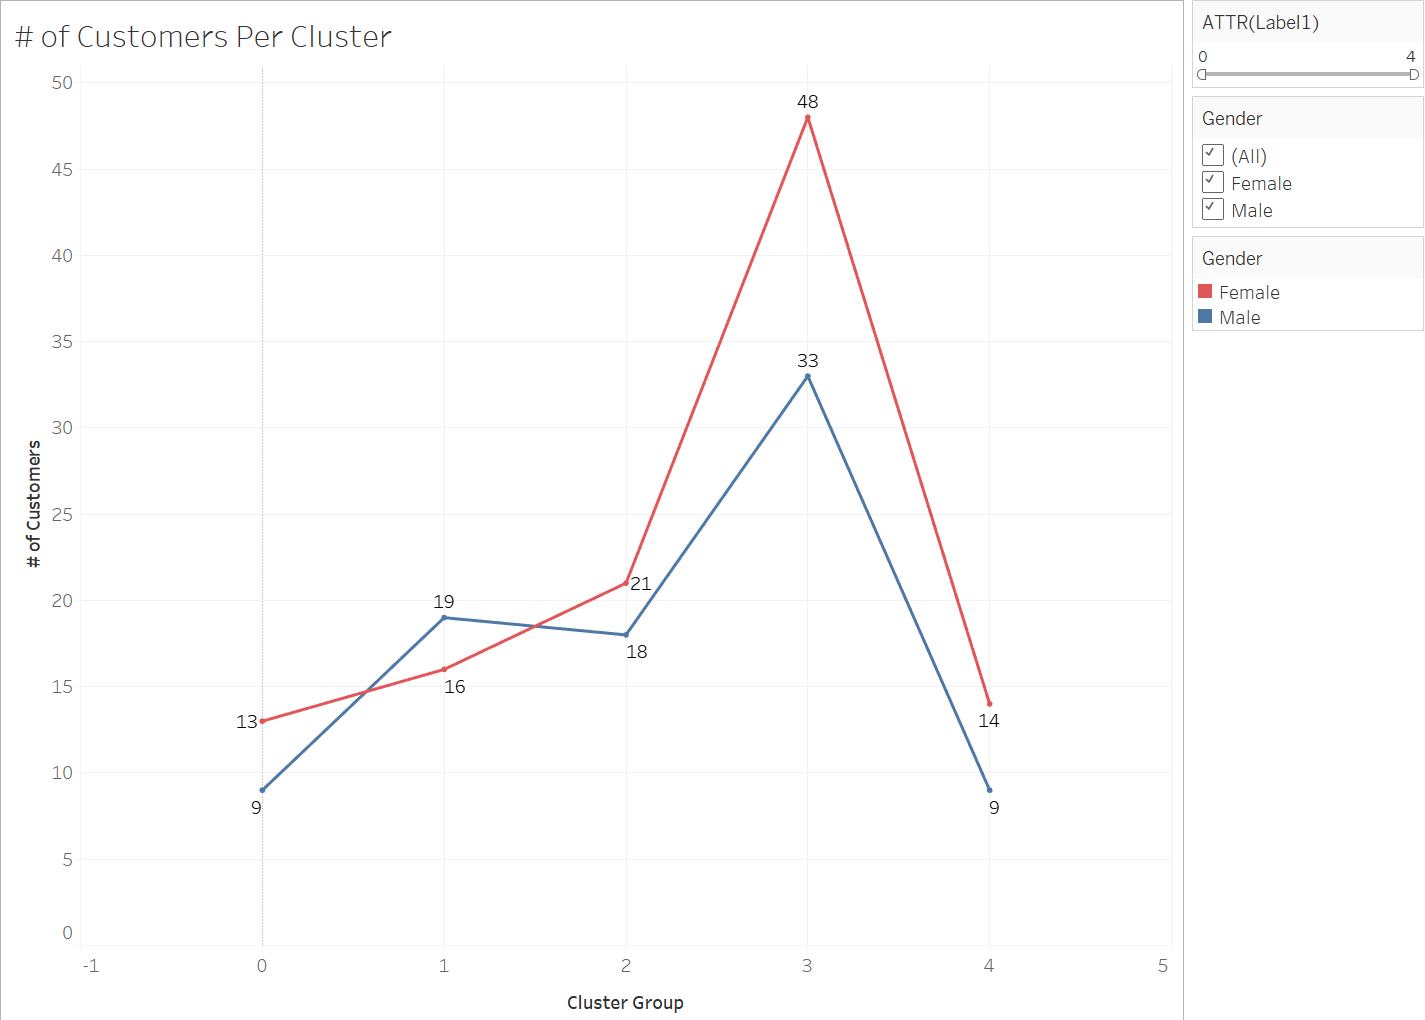

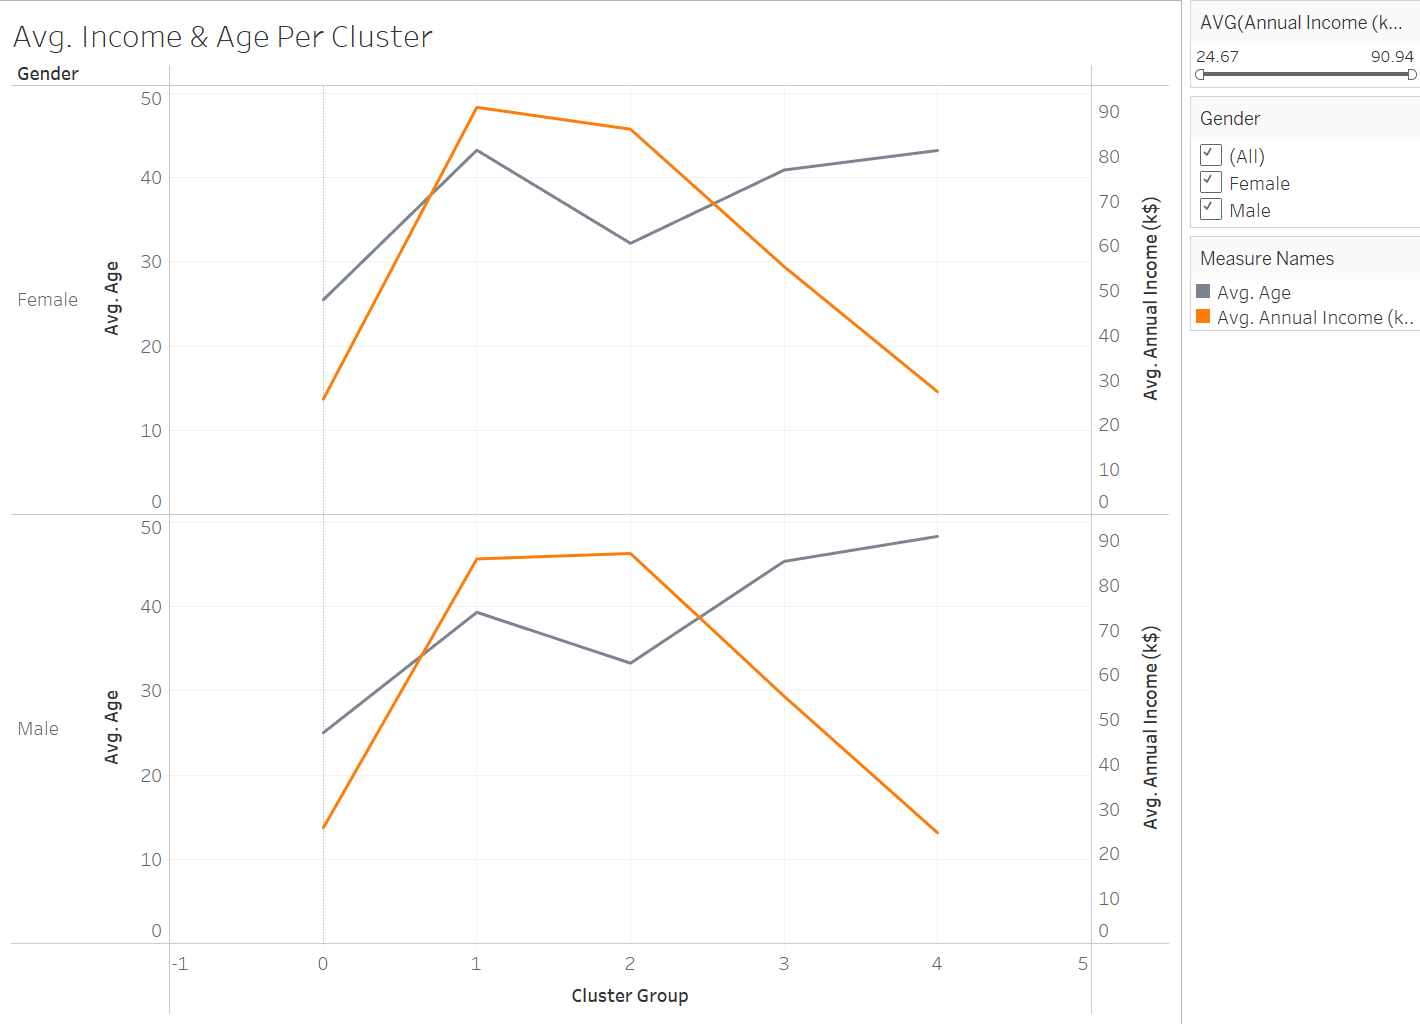

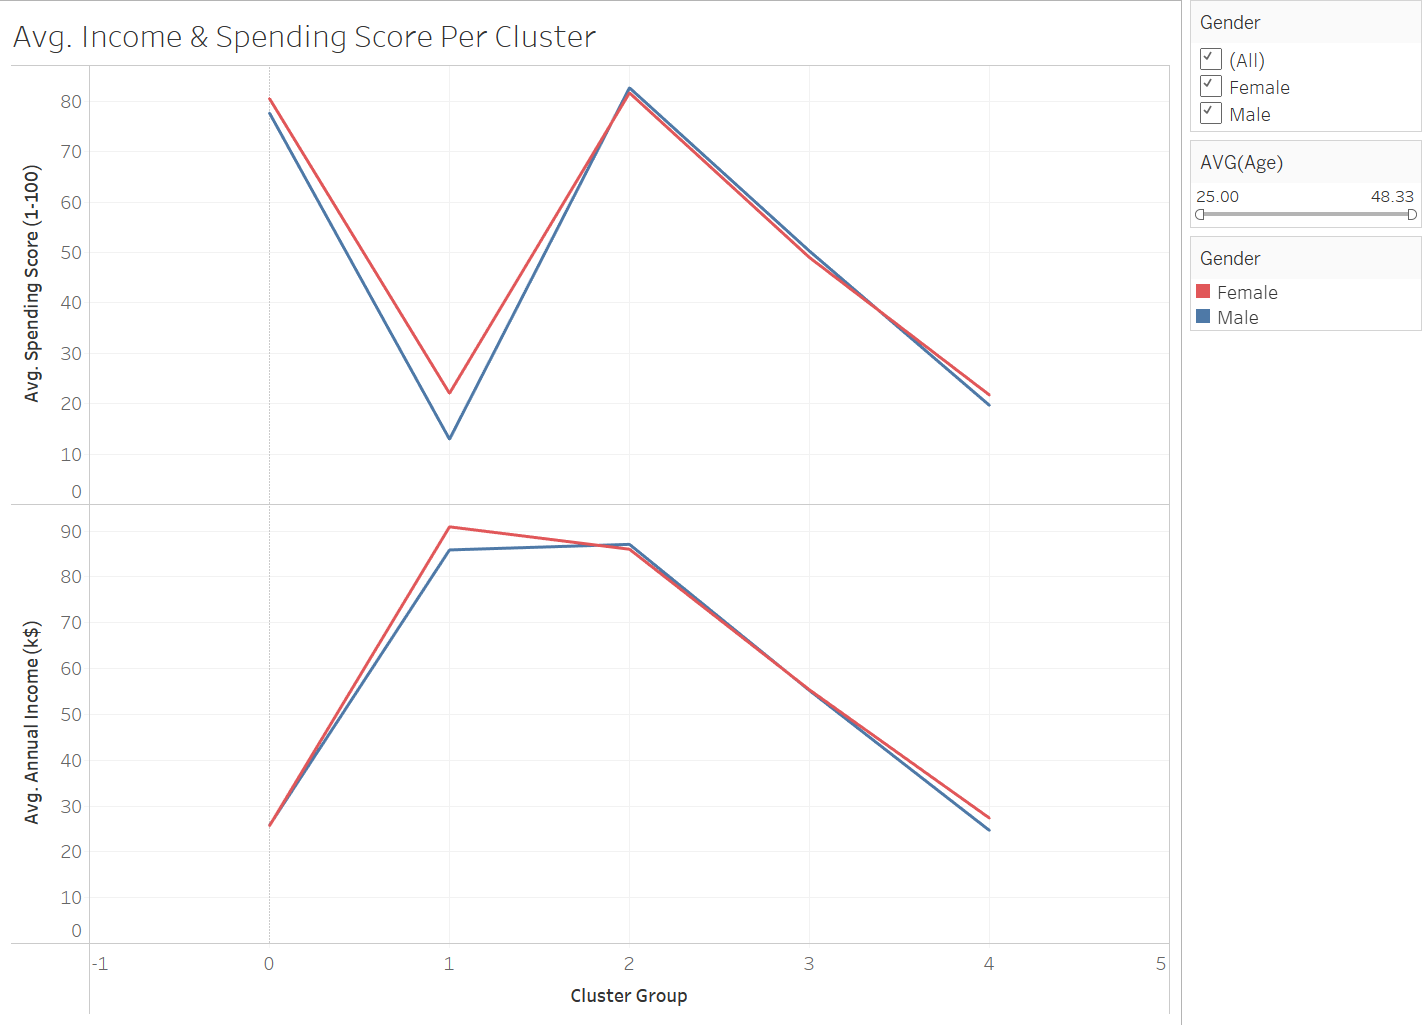

## Conclusion

The objective of this project was to segment customers based on purchasing behavior and demographics, including age, annual income, and spending score, to facilitate targeted marketing strategies. Various models were tested, and their accuracy was evaluated using the Silhouette Score. The most effective model utilized only two key features: annual income and spending score, achieving the highest Silhouette Score and revealing that these metrics were the most predictive for segmenting customer behavior. This model identified five distinct clusters: Low Income/Low Spending, Low Income/High Spending, Medium Income/Medium Spending, High Income/Low Spending, and High Income/High Spending.

The analysis showed that customer income level and spending habits were highly correlated, and using only these two features allowed for clear and actionable segment distinctions. Although age was initially included as a feature, it did not significantly improve the clustering, emphasizing that income and spending patterns were the most effective predictors for segmentation.

Based on these findings, it is recommended to:

Develop targeted promotions tailored to the identified clusters. For instance, Low Income/High Spending customers may respond well to loyalty programs or discounts, while High Income/High Spending customers could be engaged with premium product offerings and exclusive services.
Use data-driven marketing campaigns to optimize advertising budgets, focusing on clusters with high growth potential (e.g., Medium Income/Medium Spending group).
Although this analysis successfully identified meaningful customer segments, future studies could explore additional features, such as age, purchasing frequency, or product preferences, to refine segmentation further. Overall, this project demonstrates how data analytics can simplify the understanding of customer behavior, leading to more effective marketing strategies and improved business outcomes.